# Environment

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 188 folder and put all the files under Assignment1 folder, then '188/Assignment1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '188/Assignment1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '249/Project/CCS21_GNNattack_Node_injection/Yu_Zhou'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['GUnet.py', 'binary_detect.py', 'main.py', 'LICENSE', 'detection_train_dataset.py', 'process_results.py', 'Gin.py', 'random_attack.py', 'README.md', '__pycache__', 'dataset', 'data_split', 'trained_model', 'defense', 'out1', 'out2', 'wkdir', 'Sign_OPT.py', 'Single_node_injection.ipynb', '10%_injection.ipynb', 'Github.ipynb', 'wkdir02', 'wkdir02_test', 'Connected Graph.ipynb', 'test.py', 'Visualization Graphs', 'test', 'filepath.png', 'vtest.py', 'visualization.py', 'Visualization.ipynb', '#1.ipynb', '#2.ipynb']


In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

In [ ]:
import torch
print(torch.__version__)
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html

1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 4.4 MB/s 
     |████████████████████████████████| 3.5 MB 70.1 MB/s 


In [ ]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 407 kB 4.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=184d144aa42e6be2d05edb3d3dfc8d963b2cf21ddda011dccdd198b2ed654e6d
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [ ]:
cd /content/drive/My\ Drive/249/Project/CCS21_GNNattack_Node_injection/Yu_Zhou/

/content/drive/My Drive/249/Project/CCS21_GNNattack_Node_injection/Yu_Zhou


# Setup

In [ ]:
TUD = {'NCI1':0,'COIL-DEL':0,'IMDB-BINARY':1}
dataset_name = "NCI1"
injection_number = 0
injection_percentage = 0.1
initialization = 'node_mean'
connection = 'random'


# 1. 15% + 'node_mean' + 'random'
# 2. 15% + 'node_mean' + 'mode'

# Utility Functions

In [ ]:
    import torch
    import torch_geometric #torch_geometric == 1.6.1
    # import community
    import community.community_louvain
    import numpy as np
    import networkx
    import argparse
    from torch_geometric.datasets import TUDataset
    from torch_geometric.data import DataLoader
    from torch_geometric.data import Batch
    from Sign_OPT import *
    from torch_geometric.utils import to_networkx, from_networkx
    import torch_geometric.transforms as T
    from Gin import GIN, SAG, GUNet
    from time import time
    import random
    from collections import Counter



    from IPython.display import clear_output
    import matplotlib.pyplot as plt
    from numpy.random import randn
    from time import sleep

    # TUD = {'NCI1':0,'COIL-DEL':0,'IMDB-BINARY':1}
    # dataset_name = "COIL-DEL"
    device = torch.device("cuda:"+str(0) if torch.cuda.is_available() else torch.device("cpu"))

    if dataset_name in TUD.keys():
        degree_as_attr = TUD[dataset_name]
    else:
        print('invalid dataset!')
        raise(ValueError)

    if degree_as_attr:
        dataset = TUDataset(root='./dataset',name=dataset_name,use_edge_attr='False', use_node_attr=True,
        pre_transform=T.Constant(1, True))
    else:
        dataset = TUDataset(root='./dataset',name=dataset_name,use_edge_attr='False',use_node_attr=True)

    index_path = './data_split/' + dataset_name + '_'
    with open(index_path+'test_index.txt', 'r') as f:
        test_index = eval(f.read())
    test_dataset = dataset[test_index]
    input_dim = dataset.num_node_features
    output_dim = dataset.num_classes
    print('input dim: ', input_dim)
    print('output dim: ', output_dim)
    print("\n \n \n")


    num_test = len(test_dataset)

input dim:  37
output dim:  2

 
 



In [ ]:
# this part is added:
#-----------------------------------------------------------------------
def my_mode(sample):
    c = Counter(sample)
    return [k for k, v in c.items() if v == c.most_common(1)[0][1]][0]




def inject_node(x, num_inject, initialization, connection):



    # print("Edge Attributes are:",x.edge_attr)

    node_feature_dim = x.x.shape[1]
    injected_feature = torch.zeros(node_feature_dim)
    num_nodes_before_injection = x.num_nodes

    if initialization == "zero":
        pass
    elif initialization == "one":
        injected_feature = torch.ones(node_feature_dim)
    elif initialization == "random":
        Gaussian_mean = torch.mean(x.x, dim=0)
        Gaussian_std = torch.std(x.x,dim=0)
        # injected_feature = torch.empty(node_feature_dim).normal_(mean=Gaussian_mean, std=Gaussian_std)
        injected_feature = torch.empty(node_feature_dim)
        injected_feature[0].normal_(mean=Gaussian_mean[0].item(), std=Gaussian_std[0].item())
        injected_feature[1].normal_(mean=Gaussian_mean[1].item(), std=Gaussian_std[1].item())
        # print(injected_feature)
    elif initialization == "node_mean":
        injected_feature = torch.mean(x.x, dim=0)
    else:
        print(f"Unsupported Initialization method: {initialization}")
        exit()
    # inject new nodes into x
    x.x = torch.cat((x.x, torch.tensor([injected_feature.cpu().numpy() for i in range(num_inject)])))
    x.num_nodes = len(x.x)





    # connect new nodes into x
    if(connection == "no_connection"):
        pass
    elif(connection == "random"):
        for i in range(num_inject):
            node_number = i+num_nodes_before_injection
            random_node = random.randint(0,num_nodes_before_injection-1)

            new_edge_back = torch.tensor([[node_number],[random_node]])
            new_edge_front = torch.tensor([[random_node],[node_number]])

            x.edge_index = torch.cat((new_edge_front, x.edge_index, new_edge_back),1)
            if(x.edge_attr is not None):
                x.edge_attr = torch.cat((x.edge_attr, torch.tensor([[0.,1.],[0.,1.]])),0)
            
    elif(connection == "mode"):
        for i in range(num_inject):
            node_number = i+num_nodes_before_injection
            mode_node = my_mode(x.edge_index[0].tolist())

            new_edge_back = torch.tensor([[node_number],[mode_node]])
            new_edge_front = torch.tensor([[mode_node],[node_number]])

            x.edge_index = torch.cat((new_edge_front, x.edge_index, new_edge_back),1)

            if(x.edge_attr is not None):
                x.edge_attr = torch.cat((x.edge_attr, torch.tensor([[0.,1.],[0.,1.]])),0)
    else:
        print(f"Unsupported Connection method: {connection}")
        exit()

    x.num_edges = x.num_edges + num_inject

    
    return x

 # n = to_networkx(x, node_attrs=x.x, edge_attrs=x.edge_attr, to_undirected=True)
 # n = to_networkx(x, to_undirected=True)
 # n.add_edge(node_number, mode_node)
 # x = from_networkx(n)

# DEMO


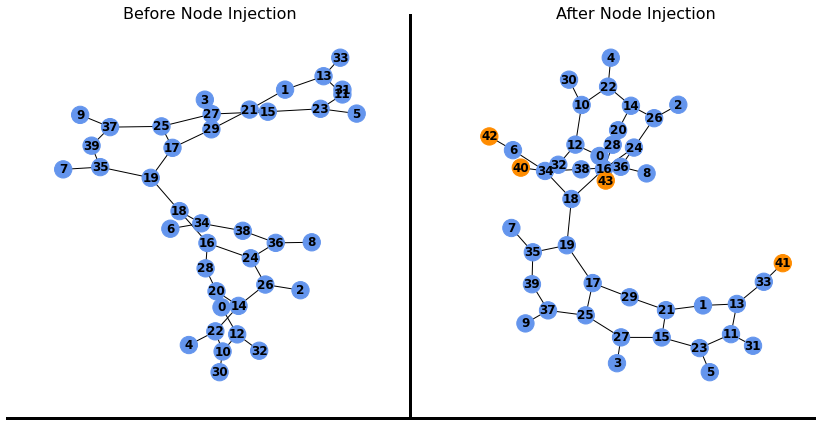

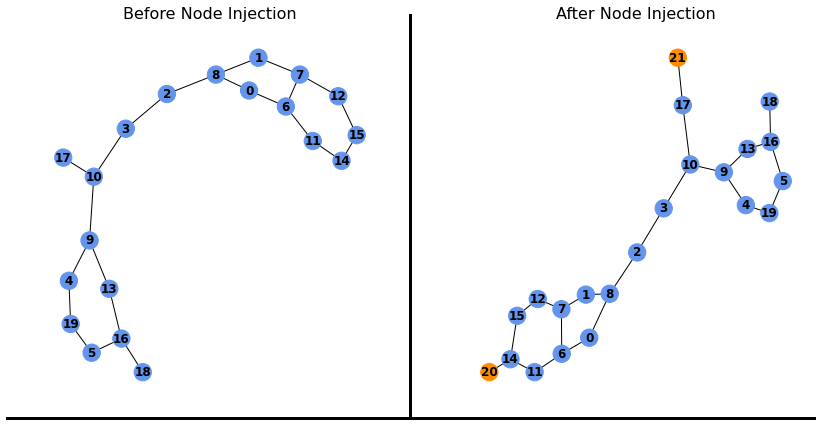

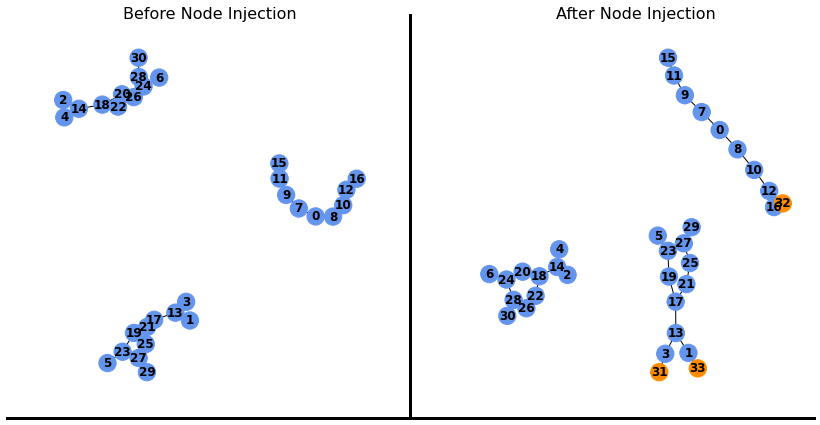

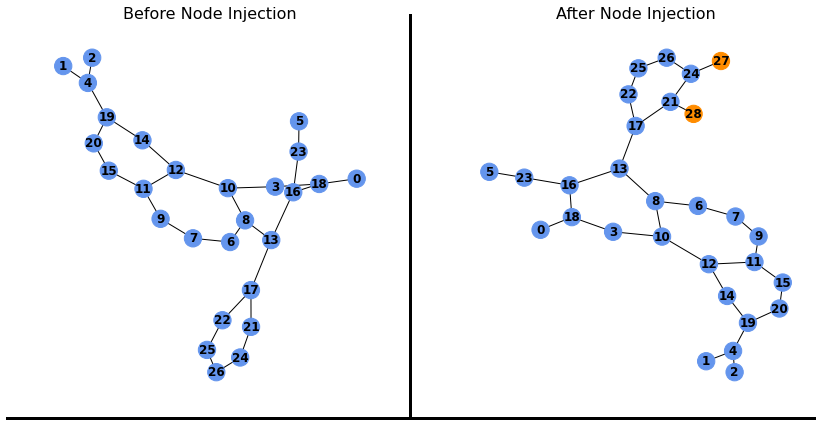

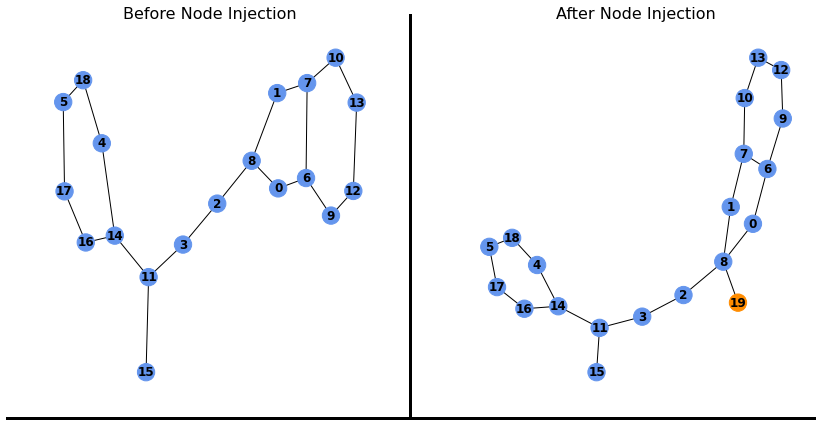

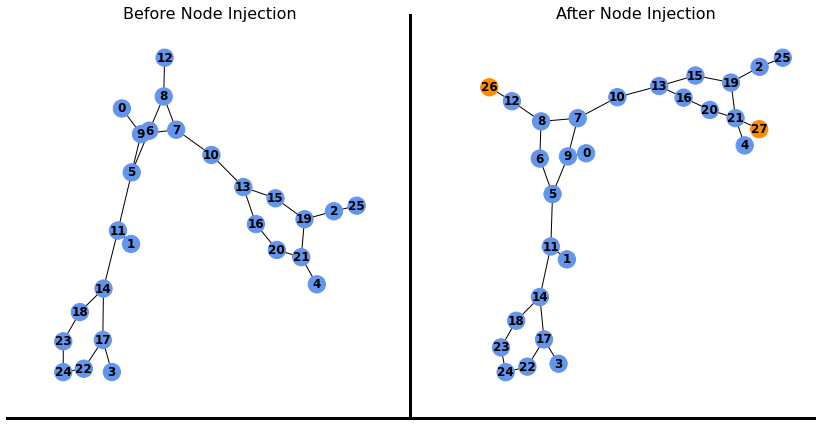

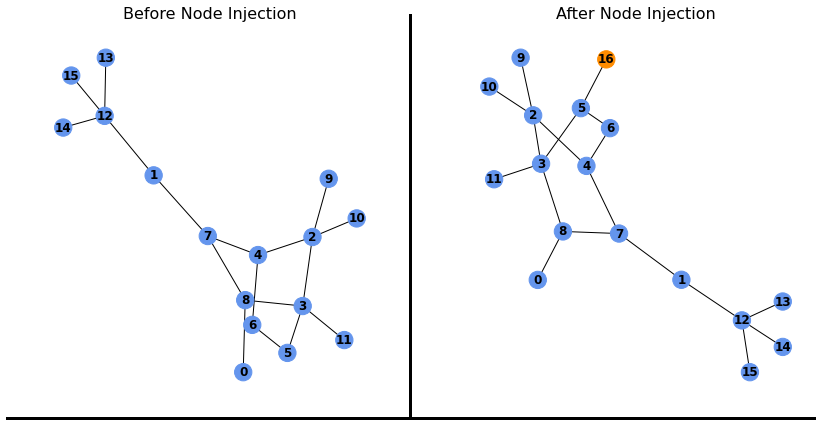

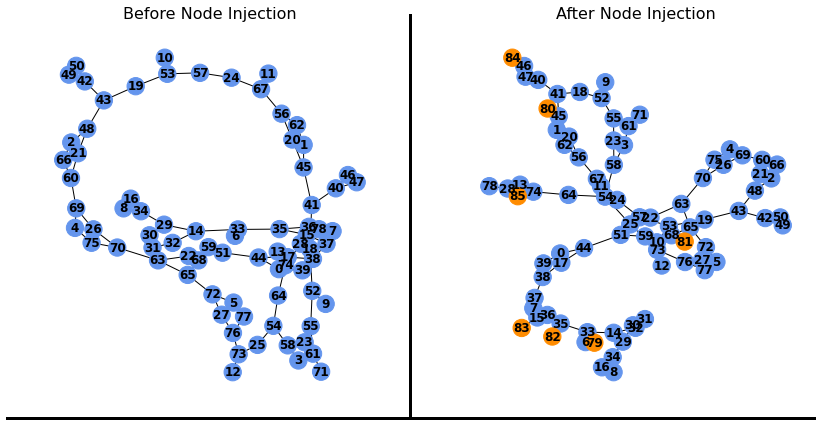

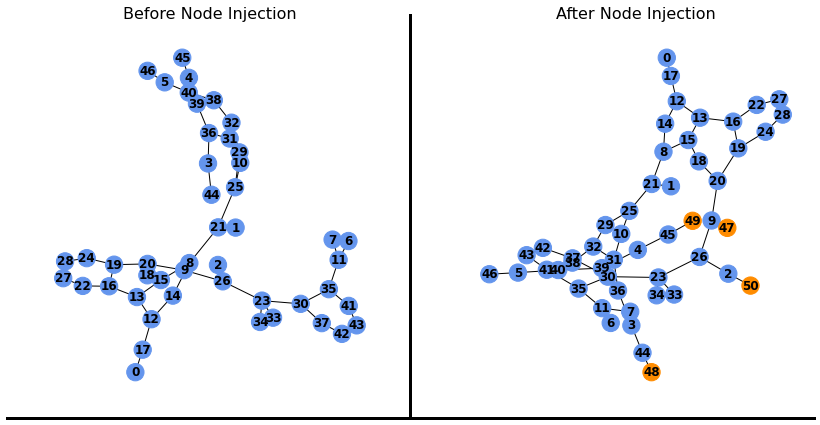

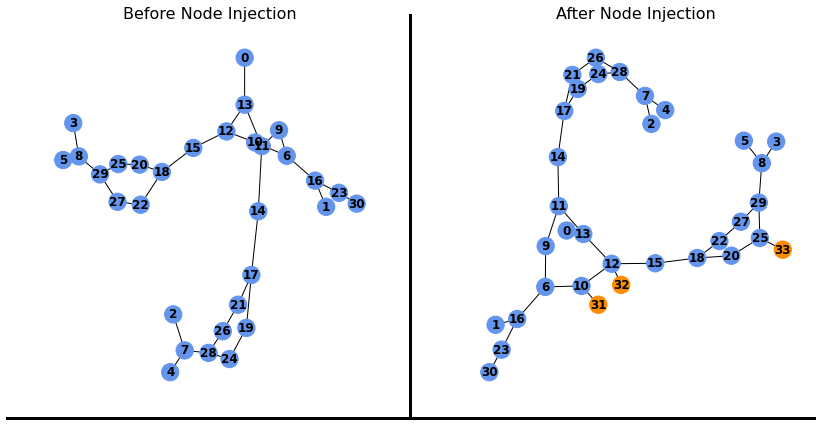

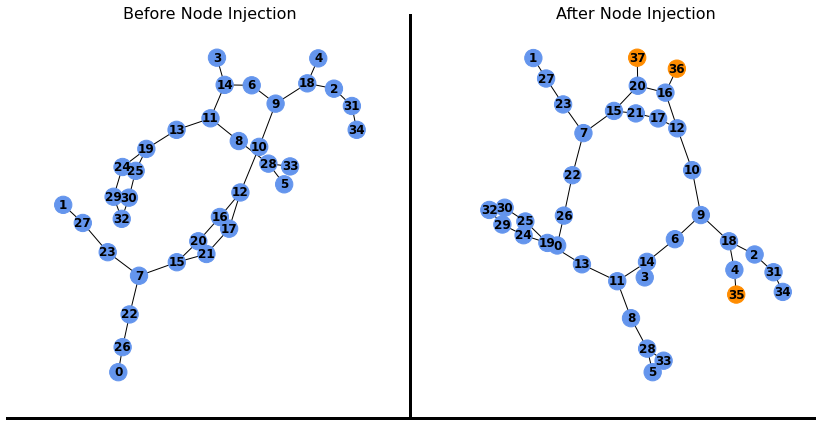

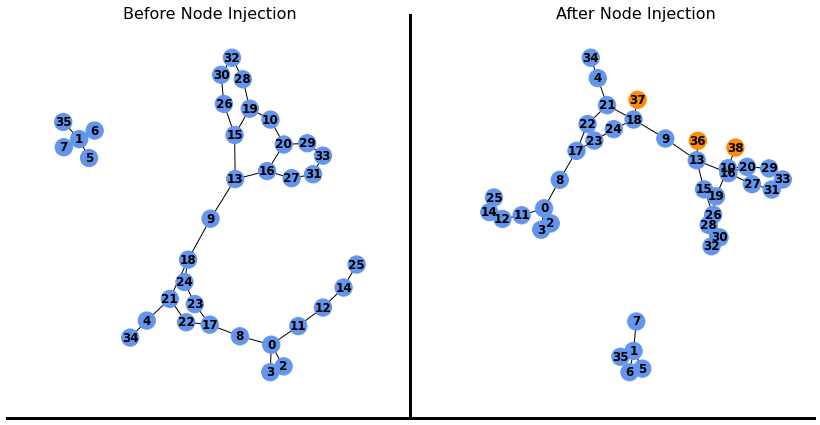

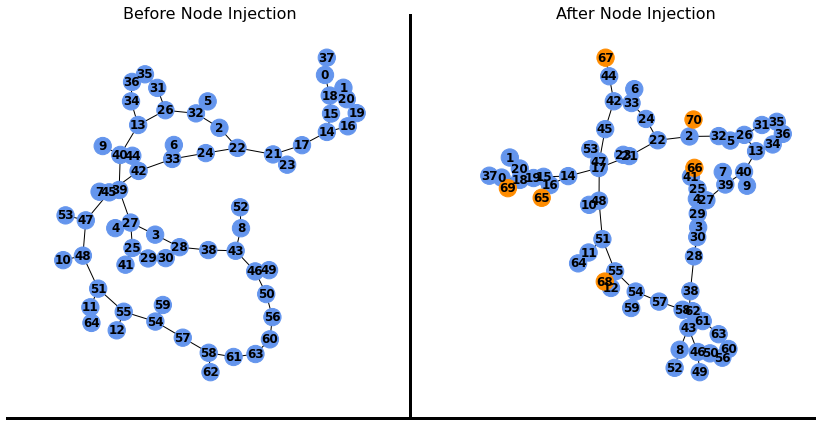

KeyboardInterrupt: ignored

In [ ]:
for i in range(0,100):
    # clear_output()
    x0 = test_dataset[i]
    G0 = to_networkx(x0, to_undirected=True)

    num_nodes_before_injection = x0.num_nodes

    if injection_number == 0 and injection_percentage == 0:
        pass
    # if num_inject not specified, then use percentage
    elif injection_number == 0 and injection_percentage != 0:
        x0 = inject_node(x0, initialization=initialization, num_inject=max(1, int(x0.num_nodes*injection_percentage)), connection = connection)
    elif injection_number != 0 and injection_percentage == 0:
        x0 = inject_node(x0, initialization=initialization, num_inject = injection_number, connection = connection)
    else:
        print("Cannot have mixed specifications of injection_number and injection_percentage!")
        exit()

    num_nodes_after_injection = x0.num_nodes

    G1 = to_networkx(x0, to_undirected=True)
    color0 = ['cornflowerblue'] * num_nodes_before_injection 
    color1 = ['cornflowerblue'] * num_nodes_before_injection + ['darkorange'] * (num_nodes_after_injection-num_nodes_before_injection)

    
    graphs = [G0,G1]
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,7))
    ax = axes.flatten()
    nx.draw_networkx(graphs[0], ax=ax[0], with_labels=True, font_weight='bold',node_color=color0)
    ax[0].set_axis_off()
    nx.draw_networkx(graphs[1], ax=ax[1], with_labels=True, font_weight='bold',node_color=color1)
    ax[1].set_axis_off()

    line1 = plt.Line2D((.5,.5),(.1,.9), color="k", linewidth=3)
    line2 = plt.Line2D((.1,.9),(.1,.1), color="k", linewidth=3)
    fig.add_artist(line1)
    fig.add_artist(line2)

    ax[0].set_title('Before Node Injection', fontsize=16)
    ax[1].set_title('After Node Injection', fontsize=16)

    # clear_output()
    plt.show()

    sleep(1.4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

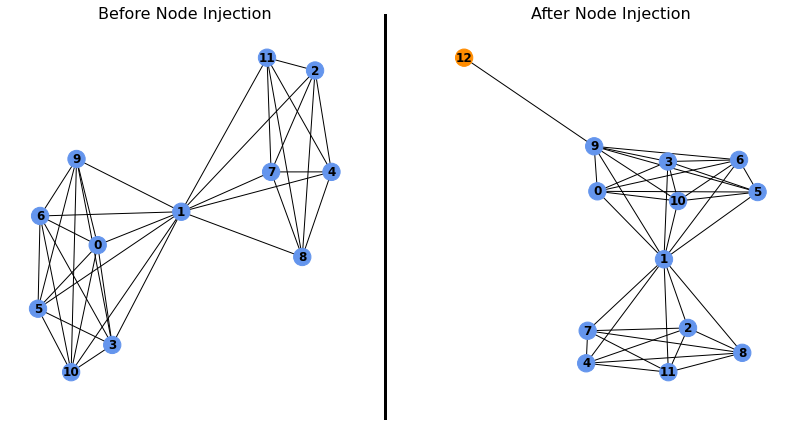

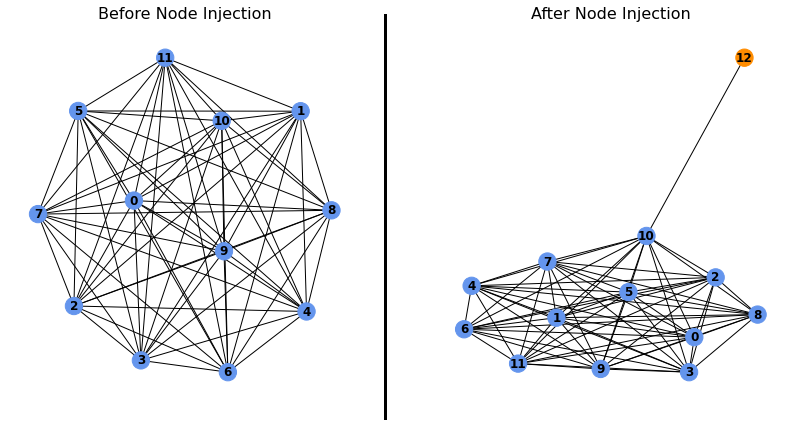

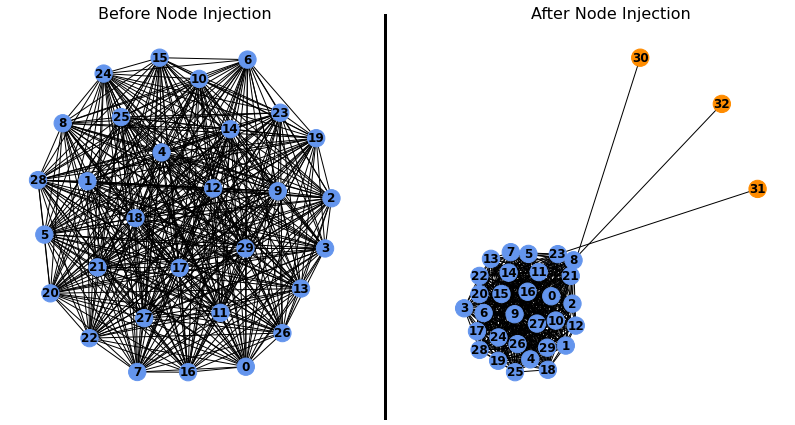

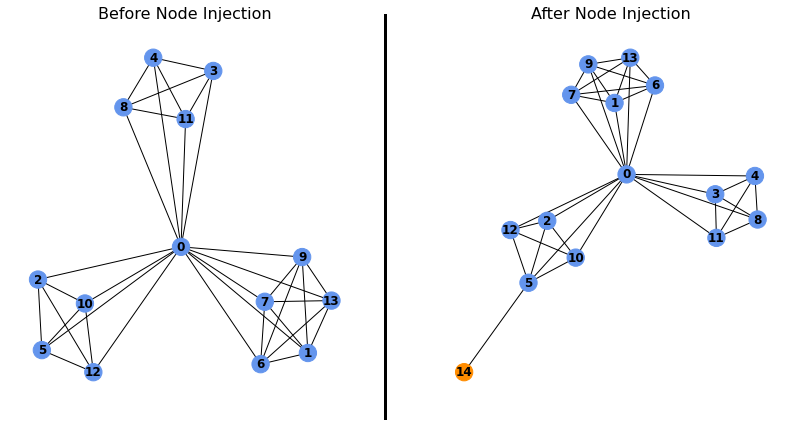

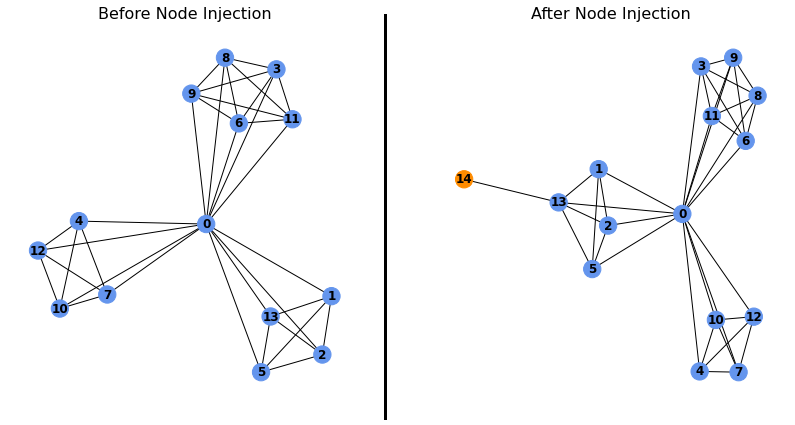

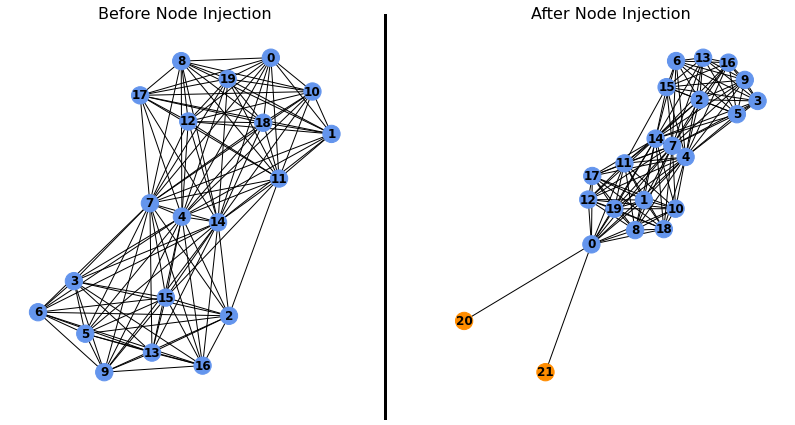

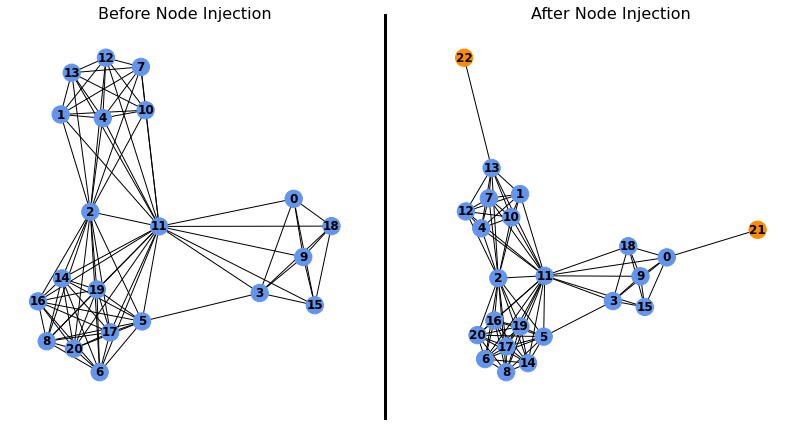

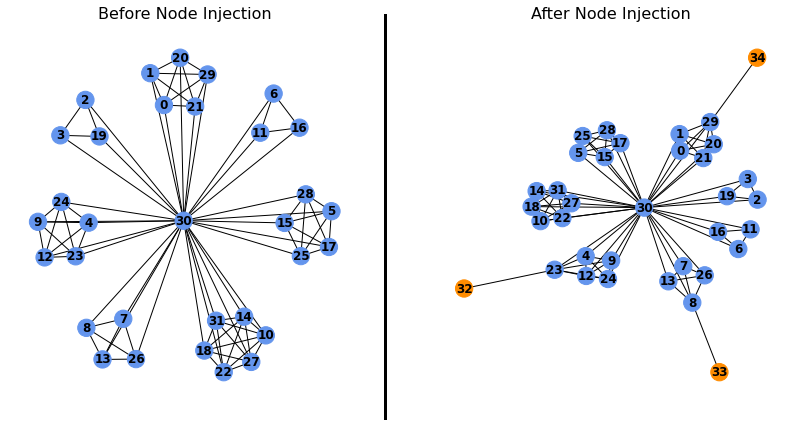

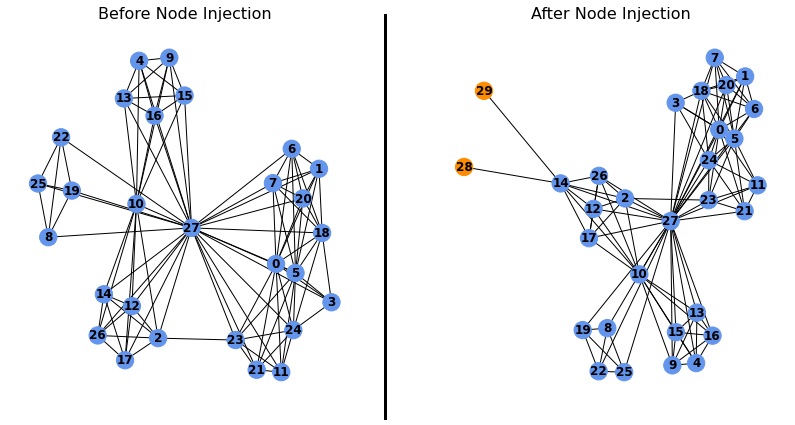

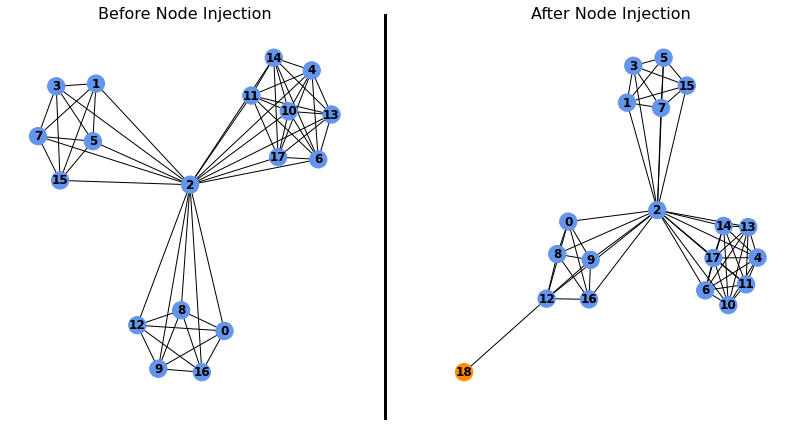

In [ ]:
for i in range(0,10):
    # clear_output()
    x0 = test_dataset[i]
    G0 = to_networkx(x0, to_undirected=True)

    num_nodes_before_injection = x0.num_nodes

    if injection_number == 0 and injection_percentage == 0:
        pass
    # if num_inject not specified, then use percentage
    elif injection_number == 0 and injection_percentage != 0:
        x0 = inject_node(x0, initialization=initialization, num_inject=max(1, int(x0.num_nodes*injection_percentage)), connection = connection)
    elif injection_number != 0 and injection_percentage == 0:
        x0 = inject_node(x0, initialization=initialization, num_inject = injection_number, connection = connection)
    else:
        print("Cannot have mixed specifications of injection_number and injection_percentage!")
        exit()

    num_nodes_after_injection = x0.num_nodes

    G1 = to_networkx(x0, to_undirected=True)
    color0 = ['cornflowerblue'] * num_nodes_before_injection 
    color1 = ['cornflowerblue'] * num_nodes_before_injection + ['darkorange'] * (num_nodes_after_injection-num_nodes_before_injection)

    
    graphs = [G0,G1]
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,7))
    ax = axes.flatten()
    nx.draw_networkx(graphs[0], ax=ax[0], with_labels=True, font_weight='bold',node_color=color0)
    ax[0].set_axis_off()
    nx.draw_networkx(graphs[1], ax=ax[1], with_labels=True, font_weight='bold',node_color=color1)
    ax[1].set_axis_off()

    line1 = plt.Line2D((.5,.5),(.1,.9), color="k", linewidth=3)
    # line2 = plt.Line2D((.1,.9),(.1,.1), color="k", linewidth=3)
    fig.add_artist(line1)
    # fig.add_artist(line2)


    # ax[0].title.set_text('Before Injection')
    # ax[1].title.set_text('After Injection')

    ax[0].set_title('Before Node Injection', fontsize=16)
    ax[1].set_title('After Node Injection', fontsize=16)


    # plt.show()



    # filepath = '/content/drive/My Drive/249/Project/CCS21_GNNattack_Node_injection/Yu_Zhou/NCI1_Graphs/graph' + str(i) + '.png' 
    # print(filepath)
    # fig.savefig('filepath')

    # filename = 'Graph' + str(i) + '.png'
    # plt.savefig(filename)
    # files.download(filename) 



    # print("x0 edge index is:",x0.x)
    # sleep(1.5)

# Draft

In [ ]:
from time import time
import random
from collections import Counter
from IPython.display import clear_output
import matplotlib.pyplot as plt
from numpy.random import randn
from time import sleep
import networkx as nx
from matplotlib.pyplot import figure

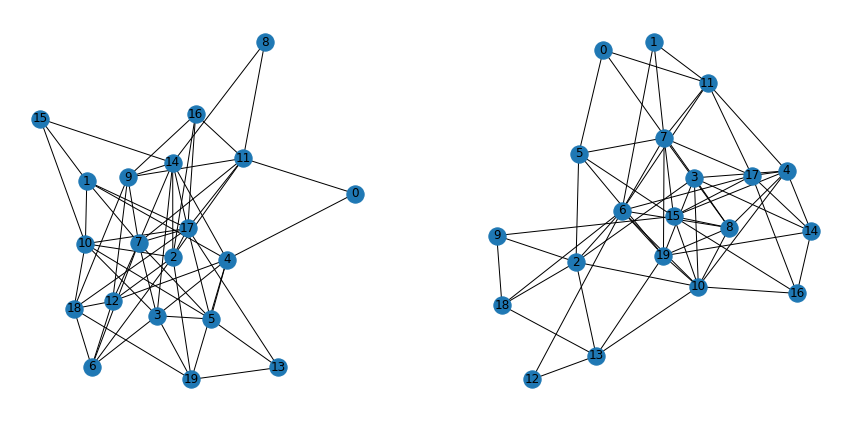

In [ ]:
graphs = [nx.gnp_random_graph(20,0.3) for _ in range(4)]

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,7.5))
ax = axes.flatten()

for i in range(2):
    nx.draw_networkx(graphs[i], ax=ax[i])
    ax[i].set_axis_off()

plt.show()

In [ ]:
for i in range(num_test):
    clear_output()
    x0 = test_dataset[i].to(device)
    G0 = to_networkx(x0, to_undirected=True)
    networkx.draw(G0, with_labels=True, font_weight='bold')
    plt.show()
    sleep(1)   

NameError: ignored

Run Visualization

In [ ]:
graphs = [nx.gnp_random_graph(20,0.3) for _ in range(4)]

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,7.5))
ax = axes.flatten()

for i in range(2):
    nx.draw_networkx(graphs[i], ax=ax[i])
    ax[i].set_axis_off()

plt.show()


for i in range(num_test):
    graphs = []
    clear_output()
    x0 = test_dataset[i].to(device)
    G0 = to_networkx(x0, to_undirected=True)
    
    networkx.draw(G0, with_labels=True, font_weight='bold')
    plt.show()
    sleep(1)   

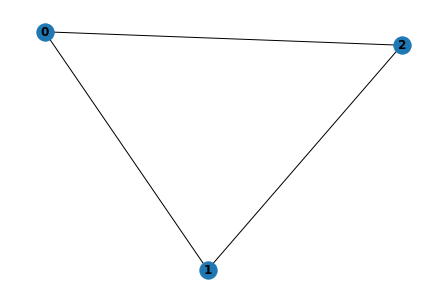

KeyboardInterrupt: ignored

In [ ]:
for i in range(num_test):
    clear_output()
    x0 = test_dataset[i].to(device)
    G0 = to_networkx(x0, to_undirected=True)
    networkx.draw(G0, with_labels=True, font_weight='bold')
    plt.show()
    sleep(1)   

# visualization with injection

In [ ]:
for i in range(0,100):
    clear_output()
    x0 = test_dataset[i]
    G0 = to_networkx(x0, to_undirected=True)

    num_nodes_before_injection = x0.num_nodes

    if injection_number == 0 and injection_percentage == 0:
        pass
    # if num_inject not specified, then use percentage
    elif injection_number == 0 and injection_percentage != 0:
        x0 = inject_node(x0, initialization=initialization, num_inject=max(1, int(x0.num_nodes*injection_percentage)), connection = connection)
    elif injection_number != 0 and injection_percentage == 0:
        x0 = inject_node(x0, initialization=initialization, num_inject = injection_number, connection = connection)
    else:
        print("Cannot have mixed specifications of injection_number and injection_percentage!")
        exit()

    num_nodes_after_injection = x0.num_nodes

    G1 = to_networkx(x0, to_undirected=True)
    color0 = ['cornflowerblue'] * num_nodes_before_injection 
    color1 = ['cornflowerblue'] * num_nodes_before_injection + ['darkorange'] * (num_nodes_after_injection-num_nodes_before_injection)

    
    graphs = [G0,G1]
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,7))
    ax = axes.flatten()
    nx.draw_networkx(graphs[0], ax=ax[0], with_labels=True, font_weight='bold',node_color=color0)
    ax[0].set_axis_off()
    nx.draw_networkx(graphs[1], ax=ax[1], with_labels=True, font_weight='bold',node_color=color1)
    ax[1].set_axis_off()

    line1 = plt.Line2D((.5,.5),(.1,.9), color="k", linewidth=3)
    # line2 = plt.Line2D((.1,.9),(.1,.1), color="k", linewidth=3)
    fig.add_artist(line1)
    # fig.add_artist(line2)


    # ax[0].title.set_text('Before Injection')
    # ax[1].title.set_text('After Injection')

    ax[0].set_title('Before Node Injection', fontsize=16)
    ax[1].set_title('After Node Injection', fontsize=16)


    plt.show()



    # filepath = '/content/drive/My Drive/249/Project/CCS21_GNNattack_Node_injection/Yu_Zhou/NCI1_Graphs/graph' + str(i) + '.png' 
    # print(filepath)
    # fig.savefig('filepath')

    # filename = 'Graph' + str(i) + '.png'
    # plt.savefig(filename)
    # files.download(filename) 



    # print("x0 edge index is:",x0.x)
    # sleep(1.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

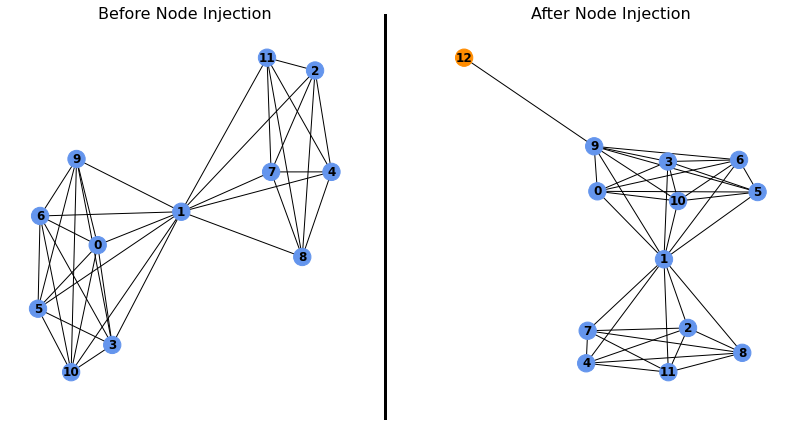

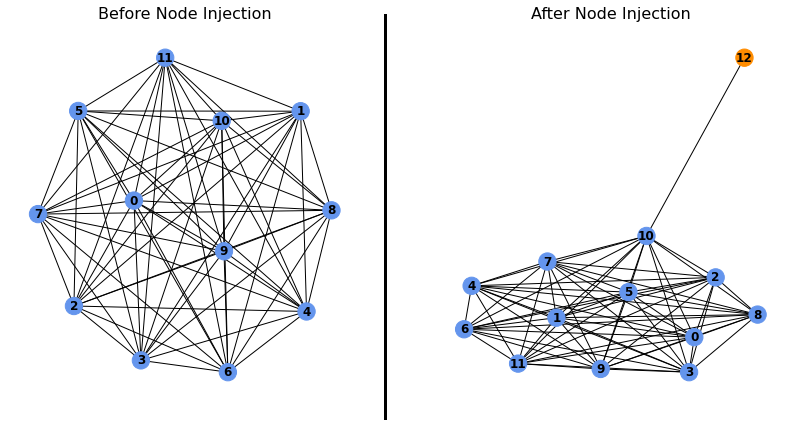

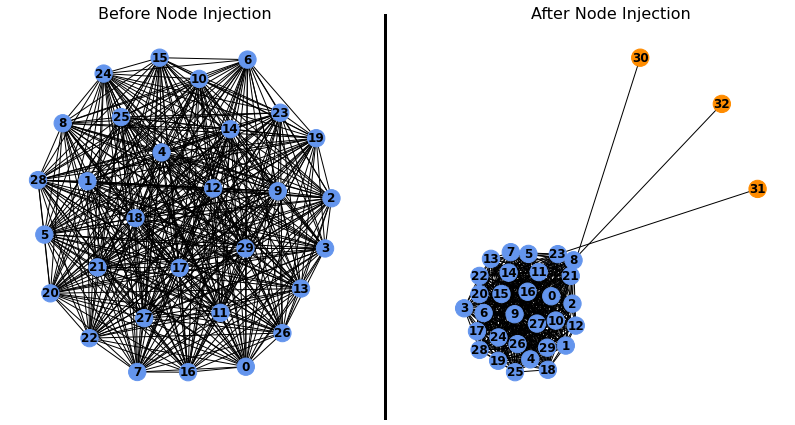

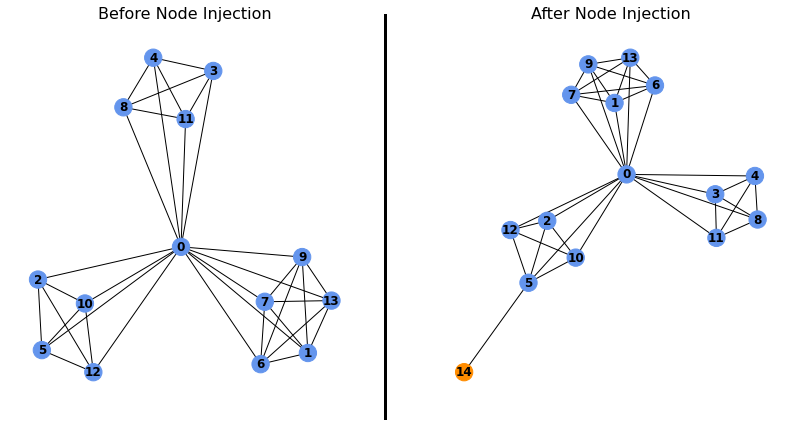

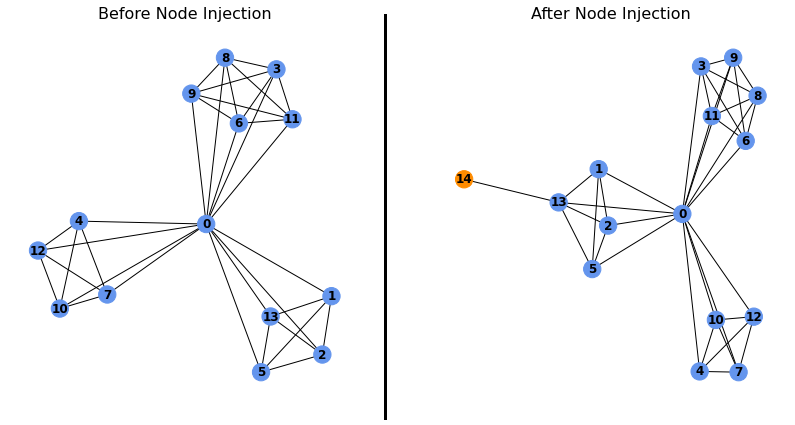

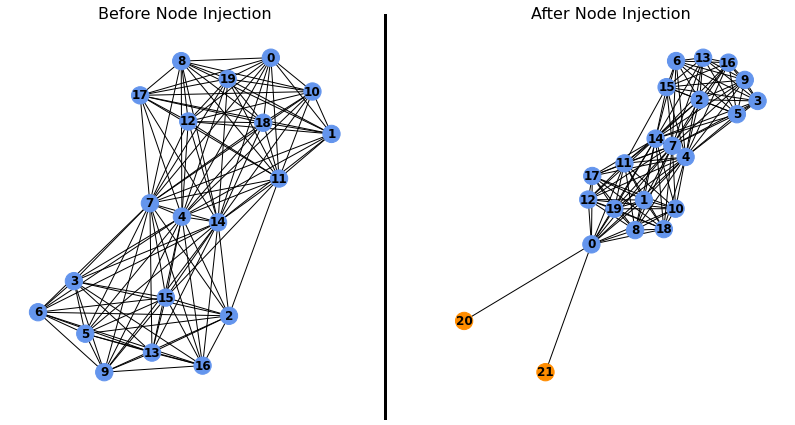

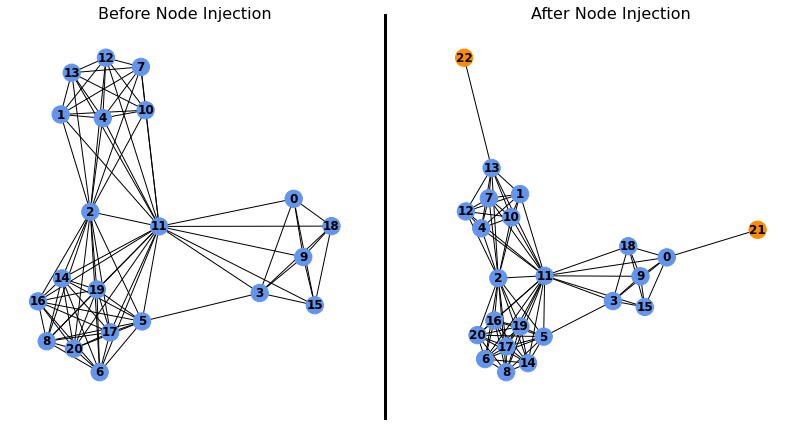

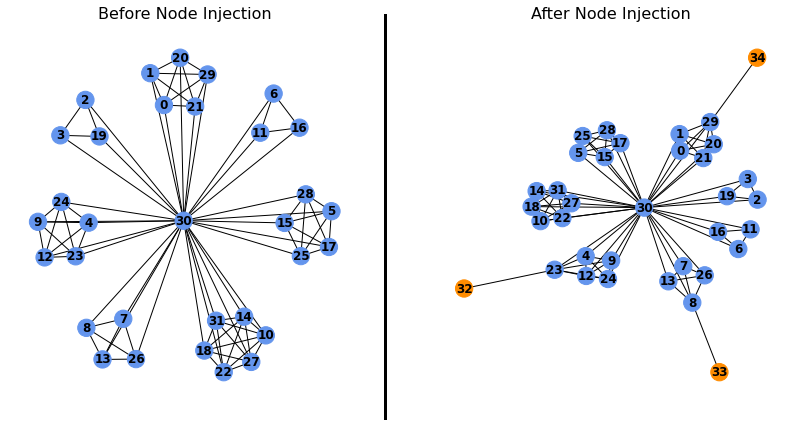

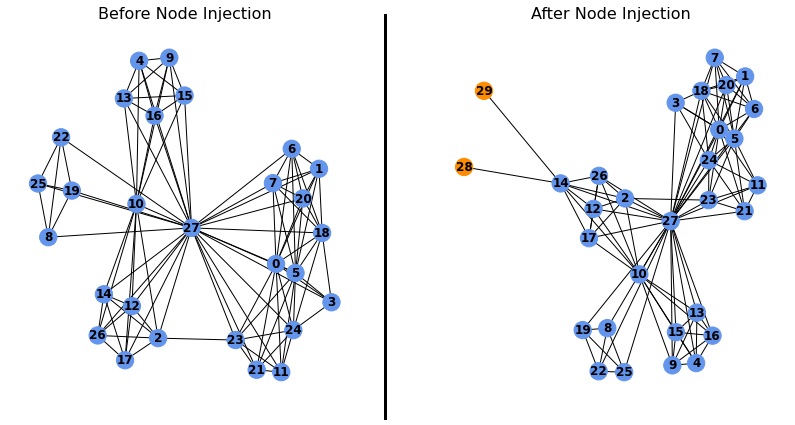

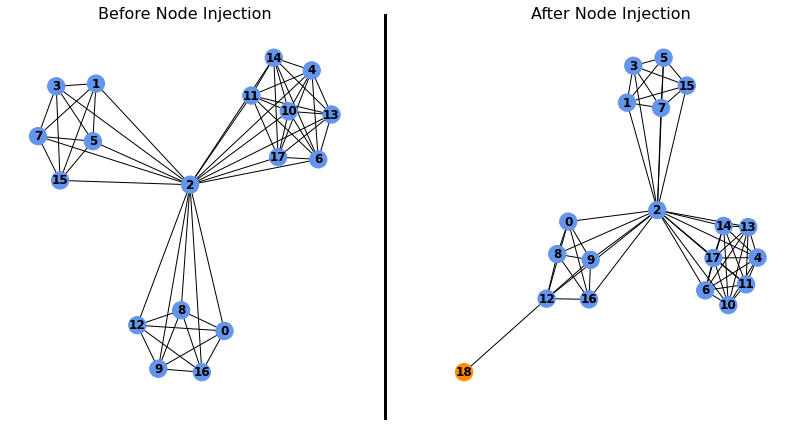

In [ ]:
for i in range(0,10):
    # clear_output()
    x0 = test_dataset[i]
    G0 = to_networkx(x0, to_undirected=True)

    num_nodes_before_injection = x0.num_nodes

    if injection_number == 0 and injection_percentage == 0:
        pass
    # if num_inject not specified, then use percentage
    elif injection_number == 0 and injection_percentage != 0:
        x0 = inject_node(x0, initialization=initialization, num_inject=max(1, int(x0.num_nodes*injection_percentage)), connection = connection)
    elif injection_number != 0 and injection_percentage == 0:
        x0 = inject_node(x0, initialization=initialization, num_inject = injection_number, connection = connection)
    else:
        print("Cannot have mixed specifications of injection_number and injection_percentage!")
        exit()

    num_nodes_after_injection = x0.num_nodes

    G1 = to_networkx(x0, to_undirected=True)
    color0 = ['cornflowerblue'] * num_nodes_before_injection 
    color1 = ['cornflowerblue'] * num_nodes_before_injection + ['darkorange'] * (num_nodes_after_injection-num_nodes_before_injection)

    
    graphs = [G0,G1]
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,7))
    ax = axes.flatten()
    nx.draw_networkx(graphs[0], ax=ax[0], with_labels=True, font_weight='bold',node_color=color0)
    ax[0].set_axis_off()
    nx.draw_networkx(graphs[1], ax=ax[1], with_labels=True, font_weight='bold',node_color=color1)
    ax[1].set_axis_off()

    line1 = plt.Line2D((.5,.5),(.1,.9), color="k", linewidth=3)
    # line2 = plt.Line2D((.1,.9),(.1,.1), color="k", linewidth=3)
    fig.add_artist(line1)
    # fig.add_artist(line2)


    # ax[0].title.set_text('Before Injection')
    # ax[1].title.set_text('After Injection')

    ax[0].set_title('Before Node Injection', fontsize=16)
    ax[1].set_title('After Node Injection', fontsize=16)


    # plt.show()



    # filepath = '/content/drive/My Drive/249/Project/CCS21_GNNattack_Node_injection/Yu_Zhou/NCI1_Graphs/graph' + str(i) + '.png' 
    # print(filepath)
    # fig.savefig('filepath')

    # filename = 'Graph' + str(i) + '.png'
    # plt.savefig(filename)
    # files.download(filename) 



    # print("x0 edge index is:",x0.x)
    # sleep(1.5)

# in visualization.py


In [ ]:
!python3 -u visualization.py --dataset NCI1 --model GIN --initialization random --injection_percentage 0.15 --connection random

input dim:  37
output dim:  2

 
 

---------------------------instance 350 basic info-----------------------------------
nodes before injection: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
edges before injection: [(0, 15), (1, 31), (2, 32), (3, 4), (3, 18), (3, 19), (3, 20), (4, 11), (4, 12), (5, 13), (5, 23), (5, 24), (5, 25), (6, 14), (6, 26), (6, 27), (6, 28), (7, 9), (7, 12), (7, 15), (8, 10), (8, 11), (8, 15), (9, 16), (10, 17), (13, 21), (13, 29), (14, 22), (14, 30), (16, 21), (16, 31), (17, 22), (17, 32), (29, 33), (30, 34), (31, 33), (32, 34), (33, 35), (34, 36)]
x0 edge index is: tensor([[ 0,  1,  2,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,
          7,  7,  7,  8,  8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 13, 14,
         14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 19, 20, 21, 21, 22, 22,
         23, 24, 25, 26, 27, 28, 29, 29, 30, 30, 31, 31, 31, 32, 

In [ ]:
!python3 -u visualization.py --dataset NCI1 --model GIN --initialization node_mean --injection_percentage 0.15 --connection random

input dim:  37
output dim:  2

 
 

---------------------------instance 380 basic info-----------------------------------
nodes before injection: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
edges before injection: [(0, 3), (0, 4), (0, 5), (0, 9), (1, 9), (1, 20), (2, 11), (2, 21), (5, 8), (5, 12), (6, 20), (7, 21), (8, 11), (8, 13), (9, 10), (10, 11), (10, 14), (12, 15), (12, 16), (15, 17), (16, 18), (17, 19), (18, 19)]
x0 edge index is: tensor([[ 0,  0,  0,  0,  1,  1,  2,  2,  3,  4,  5,  5,  5,  6,  7,  8,  8,  8,
          9,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 14, 15, 15, 16, 16,
         17, 17, 18, 18, 19, 19, 20, 20, 21, 21],
        [ 3,  4,  5,  9,  9, 20, 11, 21,  0,  0,  0,  8, 12, 20, 21,  5, 11, 13,
          0,  1, 10,  9, 11, 14,  2,  8, 10,  5, 15, 16,  8, 10, 12, 17, 12, 18,
         15, 19, 16, 19, 17, 18,  1,  6,  2,  7]], device='cuda:0')
visualization.py:65: UserWarning: Creating a tensor from a list of numpy.ndarrays